In [1]:
#### Necessary libraries ####
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import xarray as xr
import matplotlib.pyplot as plt # Matplotlib is a scientific plotting package.
import datetime                 # Datetime is a package to deal with dates.
import cartopy.crs as crs
import cartopy
from cmocean import cm
import os
import regionmask
import pandas as pd
import seaborn as sns

from Functions import * 

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline

# Data loading

In [5]:
''' Examples of data loading of moisture sources

Data is loaded per individual ensemble member for each model.
All data is converted to mm evaporative sources over the whole time period

WRF-WVT is not included yet, as well CHc Lagranto and univie FLEXPART  

There might also be a few (new) ensemble members not included yet:
- For the HAMSTER model (Ughent) there is an additional ensemble member not included yet
- Extra ensemble members of Flexpart-Watersip produced by Fandy
'''

basedir = '../Data/Scotland/'

########################################################
## WRF-WVT                                            ##
########################################################
# Just csv file because of nature of simulations       #
csv_wrf_wvt = pd.read_csv(basedir+'results WRF-WVT/ScotlandCase_Final.csv', sep=';', decimal=',', index_col=0)

########################################################
## WAM2layers                                         ##
########################################################
directory_str = basedir+"results WAM2layers/"
directory =  os.fsencode(directory_str)
n=0


for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".nc"): 
        if n==0:
            temp = xr.open_dataset(os.path.join(directory_str, filename))
            a_gridcell, lx, ly = get_grid_info(temp)
            srcs_wam2layers = temp["e_track"]
            n+=1
        else:
            temp = xr.open_dataset(os.path.join(directory_str, filename))
            a_gridcell, lx, ly = get_grid_info(temp) 
            srcs_wam2layers.values = srcs_wam2layers.values+temp["e_track"]*1.
            n+=1
        continue
    else:
        continue

srcs_wam2layers = srcs_wam2layers[0,:,:]

'''
# Data loading this way gives an error message for me while plotting, but in principe it should work
dsall = xr.open_mfdataset(basedir+'results WAM2layers/backtrack_*T00-00.nc', combine = 'nested', concat_dim='time') 
lat = dsall.latitude.values
lon = dsall.longitude.values
a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(lat, lon)
E_track_totalmm = (dsall/ a_gridcell_new) *1000 # mm
srcs_wam2layers_new = E_track_totalmm["e_track"].sum('time') # mm
'''

########################################################
## University of Vigo                                 ##
########################################################
srcs_Vigo_e1_Stohl    = xr.open_dataset(basedir+"results Uvigo/ERA5_Stohl_backwardreg.nc")["E_P"]
srcs_Vigo_e2_Sodemann = xr.open_dataset(basedir+"results Uvigo/ERA5_sodemann_reg.nc")["E_P"]

########################################################
## UTRACK - Arie Staal                                ##
## - Based on the communication with Arie             ##
## - the results should be area corrected             ##
## - given the values I assumed that the area needs   ##
## - to be in km**2, however this should be checked.  ##
########################################################
directory_str = basedir+"results Utrack Arie Staal/moisture_tracking_intercomparsion/"
directory =  os.fsencode(directory_str)

dsall = xr.open_mfdataset(basedir+'results Utrack Arie Staal/moisture_tracking_intercomparison/*_mixing48h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
a_gridcell_new, l_ew_gridcell, l_mid_gridcell = get_grid_info_new(dsall.lat.values, dsall.lon.values) #Calcluate grid cell area

srcs_utrack_e1 = dsall["moisture_source"].sum("time")*a_gridcell_new/10**6.0 #1000.0
dsall = xr.open_mfdataset(basedir+'results Utrack Arie Staal/moisture_tracking_intercomparison/*_mixing24h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e2 = dsall["moisture_source"].sum("time")*a_gridcell_new/10**6.0 #1000.0
dsall = xr.open_mfdataset(basedir+'results Utrack Arie Staal/moisture_tracking_intercomparison/*_mixing12h_dt025h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e3 = dsall["moisture_source"].sum("time")*a_gridcell_new/10**6.0 #1000.0
dsall = xr.open_mfdataset(basedir+'results Utrack Arie Staal/moisture_tracking_intercomparison/*_mixing24h_dt025h_1000p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e4 = dsall["moisture_source"].sum("time")*a_gridcell_new/10**6.0 #1000.0
dsall = xr.open_mfdataset(basedir+'results Utrack Arie Staal/moisture_tracking_intercomparison/*_mixing24h_dt010h_100p.nc', combine = 'nested', concat_dim='time')      
srcs_utrack_e5 = dsall["moisture_source"].sum("time")*a_gridcell_new/10**6.0 #1000.0

########################################################
## HAMSTER (Ghent)                                    ##
########################################################

# E1: Sodemann #
temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens1_sod08/bias_corrected_20231006120000_sod08.nc")
srcs_ghent_e1 = temp["E2P_BC"].mean("time") #Mean over time to remove time dimension


for date in range(7,9):
    temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens1_sod08/bias_corrected_2023100" + str(date) + "120000_sod08.nc")
    srcs_ghent_e1 += temp["E2P_BC"].mean("time")

# E2: FAS19 (Fremme + Sodemann, 2019) #
temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens2_fas19/bias_corrected_20231006120000_fas19.nc")
srcs_ghent_e2 = temp["E2P_BC"].mean("time") #Mean over time to remove time dimension


for date in range(7,9):
    temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens2_fas19/bias_corrected_2023100" + str(date) + "120000_fas19.nc")
    srcs_ghent_e2 += temp["E2P_BC"].mean("time")


# E3: FAS19 (Fremme + Sodemann, 2019) #
temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens3_rh20/bias_corrected_20231006120000_rh20.nc")
srcs_ghent_e3 = temp["E2P_BC"].mean("time")

for date in range(7,9):
    temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens3_rh20/bias_corrected_2023100" + str(date) + "120000_rh20.nc")
    srcs_ghent_e3 += temp["E2P_BC"].mean("time")
 
# E4: 
temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens4_allabl/bias_corrected_20231006120000_allabl.nc")
srcs_ghent_e4 = temp["E2P_BC"].mean("time")

for date in range(7,9):
    temp = xr.open_dataset(basedir+"results UGhent HAMSTER/Scotland simulations/bias_corrected/ens4_allabl/bias_corrected_2023100" + str(date) + "120000_allabl.nc")
    srcs_ghent_e4 += temp["E2P_BC"].mean("time")


########################################################
## TRACMASS Dipanjan Dey                              ## 
## Units in mm/day, so multiplied with # of           ##
## event days                                         ##
########################################################
nrdays = 3
ds_TRACMASS = xr.open_dataset(basedir+"results TRACMASS Dipanjan Dey/TRACMASS_evap_sources_06-08oct2023.nc") #Evaporative sources (and preicp?) mm/day
ds_pr_TRACMASS = xr.open_dataset(basedir+"results TRACMASS Dipanjan Dey/PR_ERA5_TRACMASS_06-08oct2023.nc") #Precip ERA5 and TRACMASS Comparison
#convert to -180 to 180 lon
ds_TRACMASS.coords['lon'] = (ds_TRACMASS.coords['lon'] + 180) % 360 - 180
ds_TRACMASS = ds_TRACMASS.sortby(ds_TRACMASS.lon)

srcs_TRACMASS = ds_TRACMASS["E_TRACMASS"]*nrdays #Units of data is mm/day but we want mm over whole time period


########################################################
## FLEXPART-Watersip TatFanCheng                      ##
########################################################
filename = basedir+"results FLEXPART_WaterSip_TatFanCheng/WaterSip_moisture_source_Scotland_20231006-20231008_Ens1.nc"
ds_flexpart_watersip_e1 = xr.open_dataset(filename)
ds_flexpart_watersip_e1.coords['lon'] = (ds_flexpart_watersip_e1.coords['lon'] + 180) % 360 - 180
srcs_flexpart_watersip_e1 = ds_flexpart_watersip_e1.sortby(ds_TRACMASS.lon)['Cb']

filename = basedir+"results FLEXPART_WaterSip_TatFanCheng/WaterSip_moisture_source_Scotland_20231006-20231008_Ens2.nc"
ds_flexpart_watersip_e2 = xr.open_dataset(filename)
ds_flexpart_watersip_e2.coords['lon'] = (ds_flexpart_watersip_e1.coords['lon'] + 180) % 360 - 180
srcs_flexpart_watersip_e2 = ds_flexpart_watersip_e2.sortby(ds_TRACMASS.lon)['Cb']

filename = basedir+"results FLEXPART_WaterSip_TatFanCheng/WaterSip_moisture_source_Scotland_20231006-20231008_Ens3.nc"
ds_flexpart_watersip_e3 = xr.open_dataset(filename)
ds_flexpart_watersip_e3.coords['lon'] = (ds_flexpart_watersip_e1.coords['lon'] + 180) % 360 - 180
srcs_flexpart_watersip_e3 = ds_flexpart_watersip_e3.sortby(ds_TRACMASS.lon)['Cb']


########################################################
## Flexpart Ru Xu                                     ##
########################################################
ds_flexpart_xu = xr.open_dataset(basedir+"results Ru_Xu_FLEXPART/scot_e_daily.nc")
srcs_flexpart_xu = ds_flexpart_xu["data"].sum("time")

########################################################
## Lagranto CHc                                       ##
########################################################
ds_lagranto_CHc = xr.open_mfdataset(basedir+"results CHc LAGRANTO/Scotland_2023_CHc_*.nc", combine = 'nested', concat_dim='time')
srcs_lagranto_CHc = ds_lagranto_CHc["N"].sum("time").squeeze().rename(dimy_N='lat', dimx_N='lon')
srcs_lagranto_CHc = srcs_lagranto_CHc.isel(lon=slice(0, -1))
srcs_lagranto_CHc = srcs_lagranto_CHc.assign_coords(lat=srcs_TRACMASS.lat[::-1], lon=srcs_TRACMASS.lon)

########################################################
## FLEXPART UniVie                                    ##
########################################################
ds_flexpart_univie = xr.open_dataset(basedir+"results univie FLEXPART/scotland_univie.nc")
srcs_flexpart_univie = (ds_flexpart_univie["moisture_uptakes_bl"]+ds_flexpart_univie["moisture_uptakes_ft"]).sum('time')

In [6]:
### Calculate (area weighted) fractional sources ###
# In WAM2layers and the flexpart simulations of Xu the lon lat names are different #
srcs_wam2layers_frac = calc_fractional_sources(srcs_wam2layers,lon_name="longitude",lat_name="latitude")
srcs_Vigo_e1_Stohl_frac = calc_fractional_sources(srcs_Vigo_e1_Stohl)
srcs_Vigo_e2_Sodemann_frac = calc_fractional_sources(srcs_Vigo_e2_Sodemann)
srcs_utrack_e1_frac = calc_fractional_sources(srcs_utrack_e1)
srcs_utrack_e2_frac = calc_fractional_sources(srcs_utrack_e2)
srcs_utrack_e3_frac = calc_fractional_sources(srcs_utrack_e3)
srcs_utrack_e4_frac = calc_fractional_sources(srcs_utrack_e4)
srcs_utrack_e5_frac = calc_fractional_sources(srcs_utrack_e5)
srcs_ghent_e1_frac  = calc_fractional_sources(srcs_ghent_e1)
srcs_ghent_e2_frac  = calc_fractional_sources(srcs_ghent_e2)
srcs_ghent_e3_frac  = calc_fractional_sources(srcs_ghent_e3)
srcs_ghent_e4_frac  = calc_fractional_sources(srcs_ghent_e4)
srcs_TRACMASS_frac  = calc_fractional_sources(srcs_TRACMASS)
srcs_flexpart_watersip_e1_frac = calc_fractional_sources(srcs_flexpart_watersip_e1)
srcs_flexpart_watersip_e2_frac = calc_fractional_sources(srcs_flexpart_watersip_e2)
srcs_flexpart_watersip_e3_frac = calc_fractional_sources(srcs_flexpart_watersip_e3)
srcs_flexpart_xu_frac = calc_fractional_sources(srcs_flexpart_xu)

# Sample plots

## CMIP REGIONS

['E.North-America', 'Caribbean', 'N.Europe', 'West&Central-Europe', 'Mediterranean', 'N.Atlantic-Ocean']


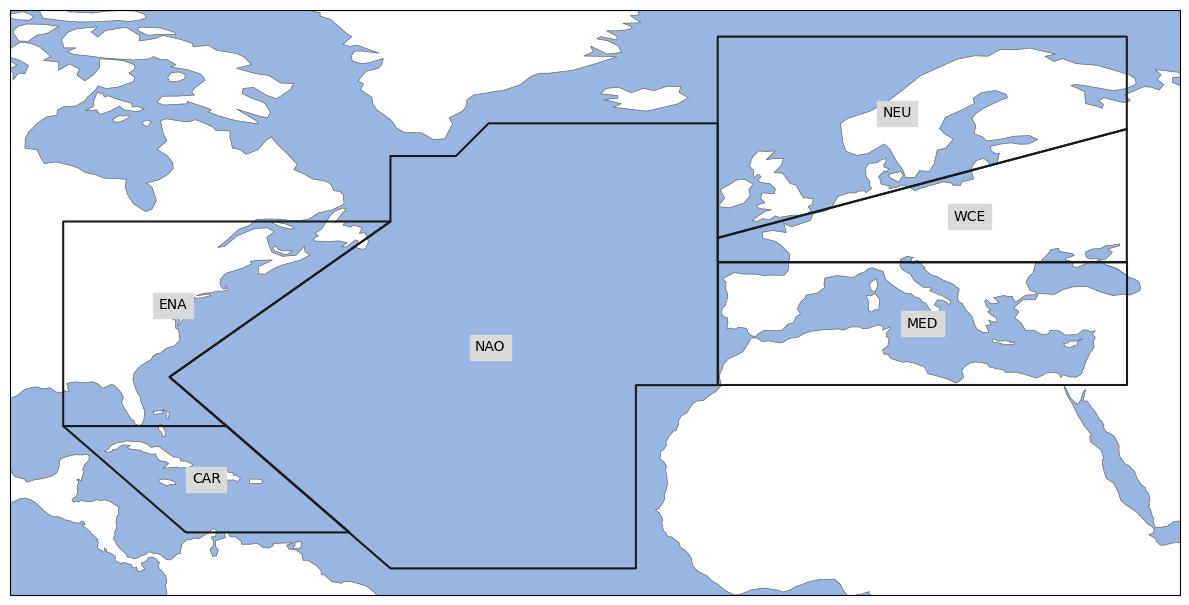

In [7]:
'''Define regions, also provides an example how to define them using the regionmask package. 

In the plots below, 'rest of the world' is not included (it is in the netcdf file). Furthermore it would be nice/logical 
to include the event region, for the Pakistan case this is now part of the SAS region. 
'''

#### Sources per region, import necessary libraries ####
my_projection = crs.PlateCarree(central_longitude=0)
#my_projection = crs.LambertConformal(central_longitude=0., central_latitude=45.0)

source_regions = xr.open_dataset("IPCCregions_Pakistancase.nc")

ar6_all = regionmask.defined_regions.ar6.all
selected_regions = ar6_all[['ENA', 'CAR', 'NEU', 'WCE', 'MED', 'NAO']]
print(selected_regions.names) #Print name of the different regions


plt.figure(figsize=(12,8))
ax = plt.axes(projection=my_projection)
ax = selected_regions.plot(ax=ax, label="abbrev", add_ocean=True)
plt.tight_layout()
plt.savefig("ScotlandRegions.png")

In [8]:
## Calculation fraction (in %) 
srcs_wam2layers_regional, weights = calc_regional_sources(srcs_wam2layers_frac,selected_regions,lon_name="longitude",lat_name = "latitude")
srcs_Vigo_e1_Stohl_regional, weights = calc_regional_sources(srcs_Vigo_e1_Stohl_frac,selected_regions)
srcs_Vigo_e2_Sodemann_regional, weights =  calc_regional_sources(srcs_Vigo_e2_Sodemann_frac,selected_regions,
                                                       weights=weights) #We can use the same weights again
srcs_utrack_e1_regional, weights = calc_regional_sources(srcs_utrack_e1_frac,selected_regions)
srcs_utrack_e2_regional, weights = calc_regional_sources(srcs_utrack_e2_frac,selected_regions,weights=weights)
srcs_utrack_e3_regional, weights = calc_regional_sources(srcs_utrack_e3_frac,selected_regions,weights=weights)
srcs_utrack_e4_regional, weights = calc_regional_sources(srcs_utrack_e4_frac,selected_regions,weights=weights)
srcs_utrack_e5_regional, weights = calc_regional_sources(srcs_utrack_e5_frac,selected_regions,weights=weights)

srcs_ghent_e1_regional, weights = calc_regional_sources(srcs_ghent_e1_frac,selected_regions)
srcs_ghent_e2_regional, weights = calc_regional_sources(srcs_ghent_e2_frac,selected_regions,weights=weights)
srcs_ghent_e3_regional, weights = calc_regional_sources(srcs_ghent_e3_frac,selected_regions,weights=weights)
srcs_ghent_e4_regional, weights = calc_regional_sources(srcs_ghent_e4_frac,selected_regions,weights=weights)

srcs_TRACMASS_regional, weights =  calc_regional_sources(srcs_TRACMASS_frac,selected_regions) 
srcs_flexpart_watersip_e1_regional, weights = calc_regional_sources(srcs_flexpart_watersip_e1_frac,selected_regions)
srcs_flexpart_watersip_e2_regional, weights = calc_regional_sources(srcs_flexpart_watersip_e2_frac,selected_regions)
srcs_flexpart_watersip_e3_regional, weights = calc_regional_sources(srcs_flexpart_watersip_e3_frac,selected_regions)
srcs_flexpart_xu_regional, weights =  calc_regional_sources(srcs_flexpart_xu_frac,selected_regions)

srcs_wrf_wvt_regional = srcs_flexpart_xu_regional.copy()
srcs_wrf_wvt_regional.values = csv_wrf_wvt.loc['fractions'][1:-2].values

/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(
/mnt/netapp2/Store_uni/home/usc/fp/aco/.conda/envs/venv_ms/lib/python3.11/site-packages/regionmask/core/mask.py:179: FutureWarn

In [9]:
srcs_regional_combined = xr.concat([srcs_wrf_wvt_regional.expand_dims(ensemble=1),
                  srcs_wam2layers_regional.expand_dims(ensemble=1),
                  srcs_Vigo_e1_Stohl_regional.expand_dims(ensemble=1),
                  srcs_Vigo_e2_Sodemann_regional.expand_dims(ensemble=1),
                  srcs_utrack_e1_regional.expand_dims(ensemble=1),
                  srcs_utrack_e2_regional.expand_dims(ensemble=1),
                  srcs_utrack_e3_regional.expand_dims(ensemble=1),
                  srcs_utrack_e4_regional.expand_dims(ensemble=1),
                  srcs_utrack_e5_regional.expand_dims(ensemble=1),
                  srcs_ghent_e1_regional.expand_dims(ensemble=1),
                  srcs_ghent_e2_regional.expand_dims(ensemble=1),
                  srcs_ghent_e3_regional.expand_dims(ensemble=1),
                  srcs_ghent_e4_regional.expand_dims(ensemble=1),
                  srcs_TRACMASS_regional.expand_dims(ensemble=1),
                  srcs_flexpart_watersip_e1_regional.expand_dims(ensemble=1),
                  srcs_flexpart_watersip_e2_regional.expand_dims(ensemble=1),
                  srcs_flexpart_watersip_e3_regional.expand_dims(ensemble=1),
                  srcs_flexpart_xu_regional.expand_dims(ensemble=1),                  
                 ],dim='ensemble')

In [10]:
nmodels, nregions = srcs_regional_combined.values.shape
values = srcs_regional_combined.values.flatten()
sources = np.tile(np.arange(nregions), nmodels)
id = np.repeat(np.array(['WRF-WVTs', 'WAM2Layers', 'StohlAndJames', 'WaterSip', 'UTrack', 'UTrack', 'UTrack', 'UTrack', 'UTrack',\
          'HAMSTER', 'HAMSTER', 'HAMSTER', 'HAMSTER', 'TRACMASS', 'WaterSip', 'WaterSip', 'WaterSip', 'WaterSip']), nregions)
df = pd.DataFrame({'values': values, 'sources': sources, 'id': id})

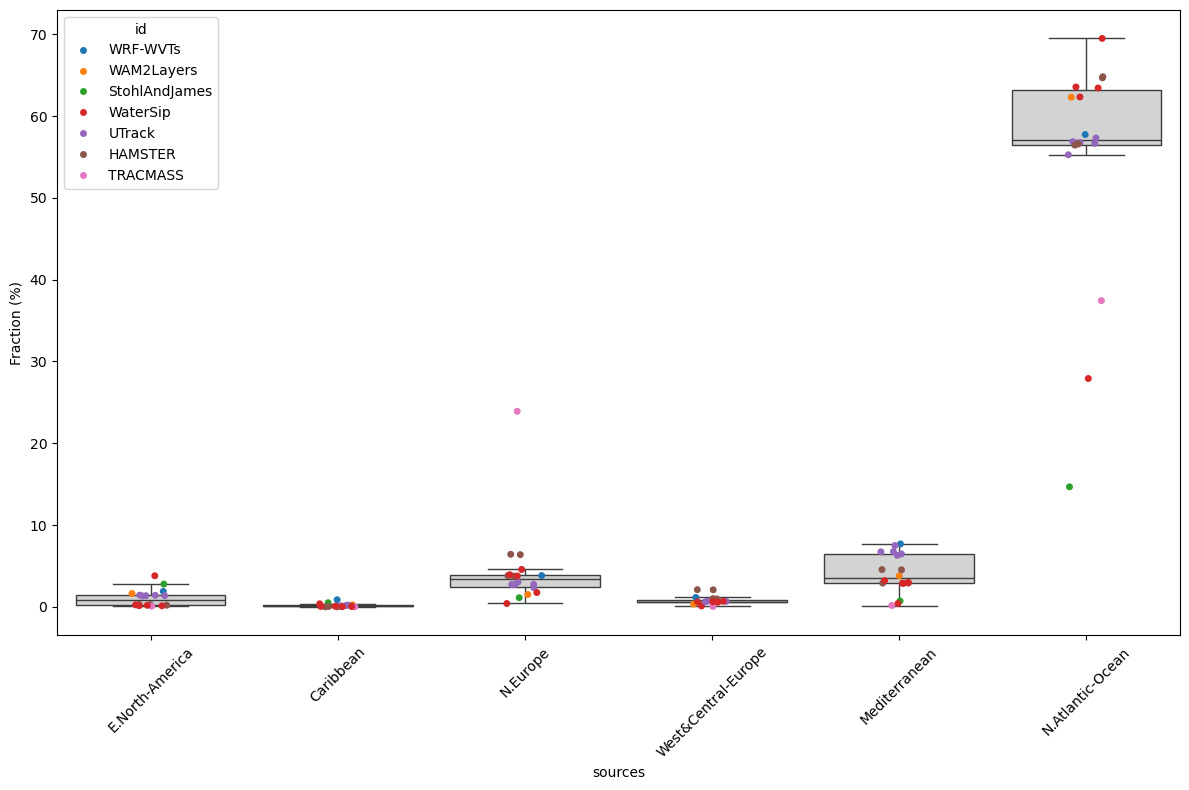

In [11]:
colors = ['red', 'blue', 'lime', 'darkgreen', 'yellow', 'yellow', 'yellow', 'yellow', 'yellow',\
          'darkgreen', 'darkgreen', 'darkgreen', 'darkgreen', 'purple', 'darkgreen', 'darkgreen', 'darkgreen', 'darkgreen']

plt.figure(figsize=(12,8))
ax = plt.subplot(111)

sns.stripplot(data=df, x=df['sources'], y=df['values'], hue=df['id'])
sns.boxplot(srcs_regional_combined, color='lightgrey', fliersize=0)

ax.set_xticks(np.arange(nregions))
ax.set_xticklabels(srcs_regional_combined.names.values, rotation=45)
ax.set_ylabel("Fraction (%)")
plt.tight_layout()

plt.savefig('Scotland_BoxPlot.png', dpi=600, bbox_inches='tight')